# Europe AirBnb price prediction - Linear Regression

## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pd.set_option('display.max_columns', None) #show all columns in our analysis

## Creating a DataFrame to work with

### Reading the csv files and merging the data into one df

In [3]:
# List of cities and their corresponding file paths
cities = {
    'Rome': "data/Rome/listings.csv",
    'Milan': "data/Milan/listings.csv",
    'Venice': "data/Venice/listings.csv",
    'Florence': "data/Florence/listings.csv",
    'Paris': "data/Paris/listings.csv",
    'London': "data/London/listings.csv",  # Note: Has multiple data types in the same row
    'Barcelona': "data/Barcelona/listings.csv"
}

# Read each file and add the city name as a column
dataframes = []
for city, path in cities.items():
    df = pd.read_csv(path, low_memory=False)
    df['City'] = city
    dataframes.append(df)

# Concatenate all dataframes
cities_df = pd.concat(dataframes, ignore_index=True)

In [4]:
cities_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,City
0,2737,https://www.airbnb.com/rooms/2737,20230907142203,2023-09-08,city scrape,Place to stay in Rome · ★4.80 · 1 bedroom · 1 ...,10 min by bus you can get to Piazza Venezia or...,It used to be an industrial area until late 80...,https://a0.muscache.com/pictures/41225252/e955...,3047,https://www.airbnb.com/users/show/3047,Elif,2008-09-18,"Rome, Italy",I am a Turkish-Italian who was born in Istanbu...,within a few hours,98%,3%,f,https://a0.muscache.com/im/pictures/user/a22d7...,https://a0.muscache.com/im/pictures/user/a22d7...,Testaccio,7.0,7.0,"['email', 'phone']",t,t,"Rome, Lazio, Italy",VIII Appia Antica,NaN,41.871360,12.482150,Private room,Private room,1,NaN,1.5 baths,NaN,1.0,"[""Hot tub"", ""Kitchen"", ""Wifi"", ""Dryer"", ""Eleva...",$75.00,7,1125,7.0,7.0,1125.0,1125.0,7.0,1125.0,NaN,t,23,53,83,358,2023-09-08,7,0,0,2014-12-26,2015-05-28,4.80,4.60,4.60,4.80,5.00,4.40,4.40,NaN,f,6,0,6,0,0.07,Rome
1,3079,https://www.airbnb.com/rooms/3079,20230907142203,2023-09-08,city scrape,Rental unit in Rome · ★4.53 · 1 bedroom · 1 be...,With the view of the Colisseum from the front ...,Monti neighborhood is one of the best areas in...,https://a0.muscache.com/pictures/e85b119c-3667...,3504,https://www.airbnb.com/users/show/3504,Laura,2008-10-08,"Rome, Italy",I've a degree in Art History\r\n,within a day,100%,10%,t,https://a0.muscache.com/im/users/3504/profile_...,https://a0.muscache.com/im/users/3504/profile_...,Monti,6.0,11.0,"['email', 'phone']",t,t,"Rome, Lazio, Italy",I Centro Storico,NaN,41.895000,12.491170,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Essentials"", ""Kitchen"", ""Window AC unit"", ""D...",$90.00,20,120,20.0,20.0,120.0,120.0,20.0,120.0,NaN,t,1,1,1,130,2023-09-08,21,0,0,2011-01-02,2022-04-30,4.53,4.38,4.62,4.71,4.86,4.81,4.43,NaN,f,6,6,0,0,0.14,Rome
2,103245,https://www.airbnb.com/rooms/103245,20230907142203,2023-09-08,city scrape,Rental unit in Rome · ★4.87 · 2 bedrooms · 4 b...,"In the center of Rome, in the Trastevere distr...",Trastevere is a characteristic and original ne...,https://a0.muscache.com/pictures/805971/9aa629...,538724,https://www.airbnb.com/users/show/538724,Carla,2011-04-27,"Rome, Italy","Hello, I'm Carla, I am 55 years old. Me and my...",within an hour,100%,100%,t,https://a0.muscache.com/im/users/538724/profil...,https://a0.muscache.com/im/users/538724/profil...,Trastevere,1.0,1.0,"['email', 'phone']",t,t,"Rome, Lazio, Italy",I Centro Storico,NaN,41.887880,12.469750,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Essentials"", ""Bathtub"", ""Kitchen"", ""Refriger...",$110.00,2,365,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,2,4,18,266,2023-09-08,389,77,8,2011-05-19,2023-09-0

In [5]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246423 entries, 0 to 246422
Data columns (total 76 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            246423 non-null  int64  
 1   listing_url                                   246423 non-null  object 
 2   scrape_id                                     246423 non-null  int64  
 3   last_scraped                                  246423 non-null  object 
 4   source                                        246423 non-null  object 
 5   name                                          246423 non-null  object 
 6   description                                   243296 non-null  object 
 7   neighborhood_overview                         137485 non-null  object 
 8   picture_url                                   246420 non-null  object 
 9   host_id                                       24

### Selecting the data that we will be working on only

In [6]:
# Define the columns to keep
columns_to_keep = ['host_response_time', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'property_type',
                   'room_type','accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
                   'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location',
                   'instant_bookable', 'City']

# Define the columns to drop
columns_to_drop = [col for col in cities_df.columns if col not in columns_to_keep]

# Drop the unwanted columns
cities_df.drop(columns=columns_to_drop, inplace=True)

### Preview the DataFrame

In [7]:
cities_df.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,246423.0,3.252038,1.871572,1.0,2.00,3.00,4.0,16.0
bedrooms,176049.0,1.611222,1.017100,1.0,1.00,1.00,2.0,50.0
beds,243573.0,1.908032,1.375107,1.0,1.00,1.00,2.0,90.0
minimum_nights,246423.0,21.831363,76.832541,1.0,1.00,2.00,4.0,1125.0
number_of_reviews,246423.0,30.995577,67.370011,0.0,1.00,7.00,28.0,2580.0
review_scores_rating,194047.0,4.629922,0.640787,0.0,4.54,4.80,5.0,5.0
review_scores_cleanliness,192259.0,4.647403,0.496651,0.0,4.50,4.80,5.0,5.0
review_scores_location,192195.0,4.748418,0.378260,0.0,4.67,4.86,5.0,5.0


In [8]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246423 entries, 0 to 246422
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   host_response_time         176373 non-null  object 
 1   host_acceptance_rate       187739 non-null  object 
 2   host_is_superhost          242112 non-null  object 
 3   neighbourhood_cleansed     246423 non-null  object 
 4   property_type              246423 non-null  object 
 5   room_type                  246423 non-null  object 
 6   accommodates               246423 non-null  int64  
 7   bathrooms_text             246172 non-null  object 
 8   bedrooms                   176049 non-null  float64
 9   beds                       243573 non-null  float64
 10  amenities                  246423 non-null  object 
 11  price                      246423 non-null  object 
 12  minimum_nights             246423 non-null  int64  
 13  number_of_reviews          24

In [9]:
cities_df.head()

,host_response_time,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_location,instant_bookable,City
0,within a few hours,3%,f,VIII Appia Antica,Private room,Private room,1,1.5 baths,NaN,1.0,"[""Hot tub"", ""Kitchen"", ""Wifi"", ""Dryer"", ""Eleva...",$75.00,7,7,4.80,4.60,4.40,f,Rome
1,within a day,10%,t,I Centro Storico,Entire rental unit,Entire home/apt,4,1 bath,1.0,1.0,"[""Essentials"", ""Kitchen"", ""Window AC unit"", ""D...",$90.00,20,21,4.53,4.62,4.81,f,Rome
2,within an hour,100%,t,I Centro Storico,Entire rental unit,Entire home/apt,6,1 bath,2.0,4.0,"[""Essentials"", ""Bathtub"", ""Kitchen"", ""Refriger...",$110.00,2,389,4.87,4.90,4.92,t,Rome
3,within a few hours,100%,t,I Centro Storico,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Pac...",$105.00,2,203,4.81,4.91,4.99,f,Rome
4,within an hour,100%,f,I Centro Storico,Entire rental unit,Entire home/apt,3,1 bath,1.0,2.0,"[""Essentials"", ""Kitchen"", ""Refrigerator"", ""Loc...",$94.00,3,289,4.18,4.28,4.47,t,Rome


## Data preprocessing

### Identify columns with mixed types

In [10]:
for col in cities_df.columns:
    unique_types = cities_df[col].apply(type).unique()
    if len(unique_types) > 1:
        print(f"Column '{col}' has mixed types: {unique_types}")

Column 'host_response_time' has mixed types: [<class 'str'> <class 'float'>]
Column 'host_acceptance_rate' has mixed types: [<class 'str'> <class 'float'>]
Column 'host_is_superhost' has mixed types: [<class 'str'> <class 'float'>]
Column 'bathrooms_text' has mixed types: [<class 'str'> <class 'float'>]


#### Handling host_acceptance_rate column

In [11]:
# Convert host_acceptance_rate to a float after stripping the '%' sign
cities_df['host_acceptance_rate'] = cities_df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100

# Fill the NaN's with the mean of the column
cities_df.host_acceptance_rate = cities_df.host_acceptance_rate.fillna(cities_df.host_acceptance_rate.mean())

#### Handling host_response_time column

In [12]:
cities_df['host_response_time'].fillna('Unknown', inplace=True)

#### Handling host_is_superhost column

In [13]:
# Fill in the Nan values in host_is_superhost column with its mode
cities_df['host_is_superhost'].fillna(cities_df['host_is_superhost'].mode()[0], inplace=True)

#### Handling bathrooms_text column

In [14]:
# Function to extract numeric part from the string
def extract_bathroom_number(text):
    if pd.isnull(text):
        return 0.5 # Return 0.5 if a null is encountered (every accomodation has atleast one shared bathroom)
    if 'half-bath' in text.lower():
        return 0.5  # Return 0.5 for shared bathrooms
    match = re.search(r'(\d+\.?\d*)', text)
    return float(match.group(1)) if match else text

# Apply the function to the 'bathrooms_text' column
cities_df['bathrooms'] = cities_df['bathrooms_text'].apply(extract_bathroom_number)

# Drop the original 'bathrooms_text' column as is no longer needed
cities_df.drop('bathrooms_text', axis=1, inplace=True)

### Checking for NaN's

In [15]:
cities_df.isnull().sum()

host_response_time               0
host_acceptance_rate             0
host_is_superhost                0
neighbourhood_cleansed           0
property_type                    0
room_type                        0
accommodates                     0
bedrooms                     70374
beds                          2850
amenities                        0
price                            0
minimum_nights                   0
number_of_reviews                0
review_scores_rating         52376
review_scores_cleanliness    54164
review_scores_location       54228
instant_bookable                 0
City                             0
bathrooms                        0
dtype: int64

#### Handling bedrooms column

In [16]:
#Estimating the number of bedrooms based on 'accommodates' and 'property_type' columns and then fill the NaN's

# Vectorized function to estimate bedrooms
def estimate_bedrooms(accommodates, property_type, current_bedrooms):
    # If bedrooms are already present, just return them
    bedrooms = current_bedrooms.copy()
    
    # Estimate bedrooms only where they are NaN
    mask = bedrooms.isna()
    
    # All private accomodations get 1 bedroom
    bedrooms[mask & (property_type == 'Private room')] = 1
    
    # Non-private accomodations with accommodates <= 3 get 1 bedroom
    bedrooms[mask & (accommodates <= 3) & (property_type != 'Private room')] = 1
    
    # Non-private accomodations with accommodates == 4 get 2 bedrooms
    bedrooms[mask & (accommodates == 4) & (property_type != 'Private room')] = 2
    
    # Non-private accomodations with accommodates == 5 get 2 bedrooms
    bedrooms[mask & (accommodates == 5) & (property_type != 'Private room')] = 2
    
    # Accommodates == 6 gets 3 bedrooms
    bedrooms[mask & (accommodates == 6)] = 3
    
    # Other cases get accommodates divided by 2, rounded up
    bedrooms[mask & (accommodates > 6)] = np.ceil(accommodates[mask & (accommodates > 6)] / 2.0)
    
    return bedrooms

# Apply the vectorized function to estimate bedrooms
cities_df['bedrooms'] = estimate_bedrooms(cities_df['accommodates'], cities_df['property_type'], cities_df['bedrooms'])

#### Handling beds column

In [17]:
# Filling the NaN's in 'beds' based on the number of people an accomodation can host
def estimate_beds(row):
    if pd.isnull(row['beds']):
        if row['accommodates'] <= 2:
            return 1
        else:
            # Assuming 2 persons per bed for larger accommodations
            return row['accommodates'] // 2 + row['accommodates'] % 2
    else:
        return row['beds']

# Apply the function to the DataFrame
cities_df['beds'] = cities_df.apply(estimate_beds, axis=1)

#### Handling review_scores_rating column

In [18]:
# We assume no rating received and assign 0 where Nan's are found
cities_df.review_scores_rating = cities_df.review_scores_rating.fillna(0)

#### Handling review_scores_cleanliness column

In [19]:
# We assume no rating received and assign 0 where Nan's are found
cities_df.review_scores_cleanliness = cities_df.review_scores_cleanliness.fillna(0)

#### Handling review_scores_location column

In [20]:
# We assume no rating received and assign 0 where Nan's are found
cities_df.review_scores_location = cities_df.review_scores_location.fillna(0)

### Further data manipulation

In [21]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246423 entries, 0 to 246422
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   host_response_time         246423 non-null  object 
 1   host_acceptance_rate       246423 non-null  float64
 2   host_is_superhost          246423 non-null  object 
 3   neighbourhood_cleansed     246423 non-null  object 
 4   property_type              246423 non-null  object 
 5   room_type                  246423 non-null  object 
 6   accommodates               246423 non-null  int64  
 7   bedrooms                   246423 non-null  float64
 8   beds                       246423 non-null  float64
 9   amenities                  246423 non-null  object 
 10  price                      246423 non-null  object 
 11  minimum_nights             246423 non-null  int64  
 12  number_of_reviews          246423 non-null  int64  
 13  review_scores_rating       24

#### Handling price column

In [22]:
# Clean the 'price' column by removing dollar signs and converting to float
cities_df['price'] = cities_df['price'].replace('[\$,]', '', regex=True).astype('float32')

#### Handling amenities column

In [23]:
## Create a list of amenities that we are interested in
amenities_to_look_for = ['Wifi', 'Kitchen', 'Paid parking on premises']


# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Filter the amenities in rome_df to only include the top 5
cities_df['selected_amenities'] = cities_df['amenities'].apply(
    lambda x: [amenity for amenity in x if amenity in amenities_to_look_for]
)

# Fit and transform the 'selected_amenities' column
amenities_encoded = mlb.fit_transform(cities_df['selected_amenities'])

# Create a DataFrame from the encoded amenities
selected_amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_)

# Concatenate the new DataFrame with the original one (making sure indexes are aligned)
cities_df = pd.concat([cities_df.reset_index(drop=True), selected_amenities_df.reset_index(drop=True)], axis=1)

# Drop the original 'amenities' and 'selected_amenities' columns as they are no longer needed
cities_df.drop(['amenities', 'selected_amenities'], axis=1, inplace=True)

### Converting categorical data to integers

#### Mapping the host_response_time to an ordinal scale with a meaningul order

In [24]:
# Map the ordinal feature 'host_response_time' to an ordinal scale
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    'Unknown': 0
}

cities_df['host_response_time'] = cities_df['host_response_time'].map(response_time_mapping)

#### Encoding the rest of the columns

In [25]:
# List of columns to encode
columns_to_encode = ['host_response_time', 'host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type',
                     'instant_bookable', 'City']

le = LabelEncoder()

# Loop through each column and apply LabelEncoder
for column in columns_to_encode:
    cities_df[column] = le.fit_transform(cities_df[column])

## Exploratory data analysis

### Visualize the distribution of values for each column.

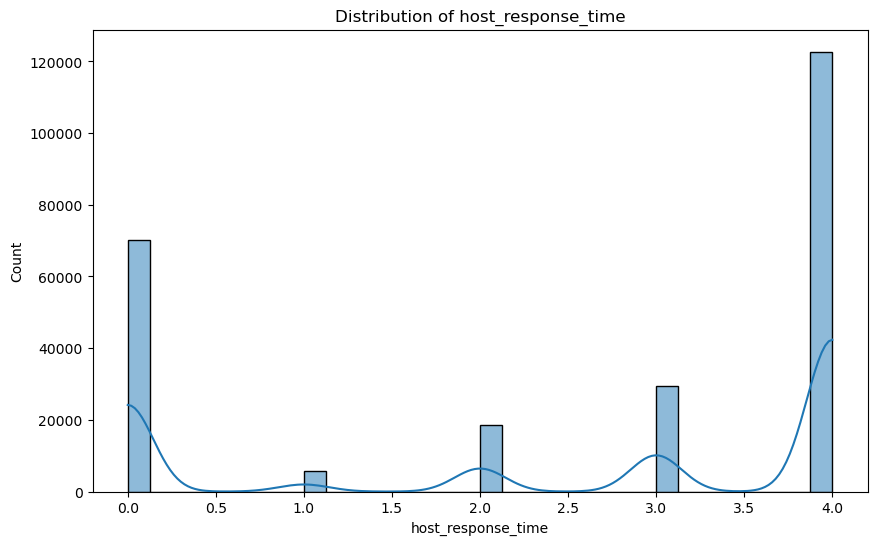

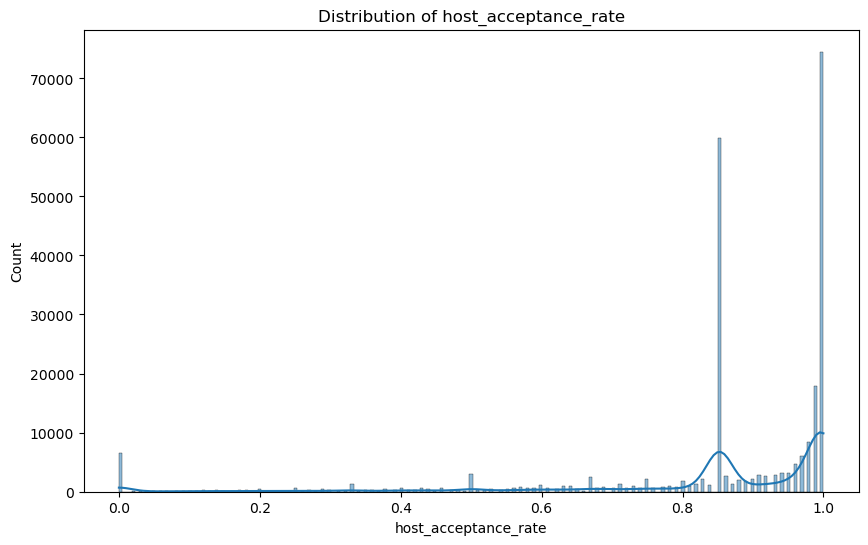

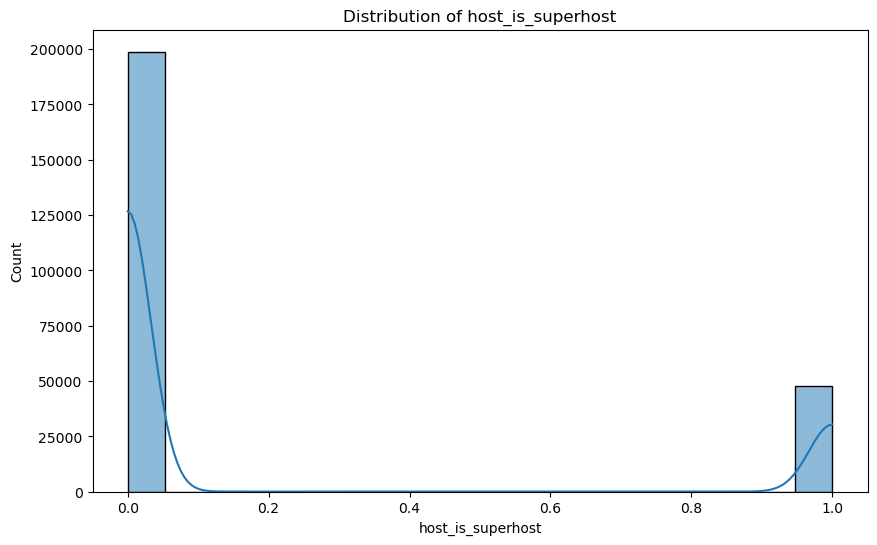

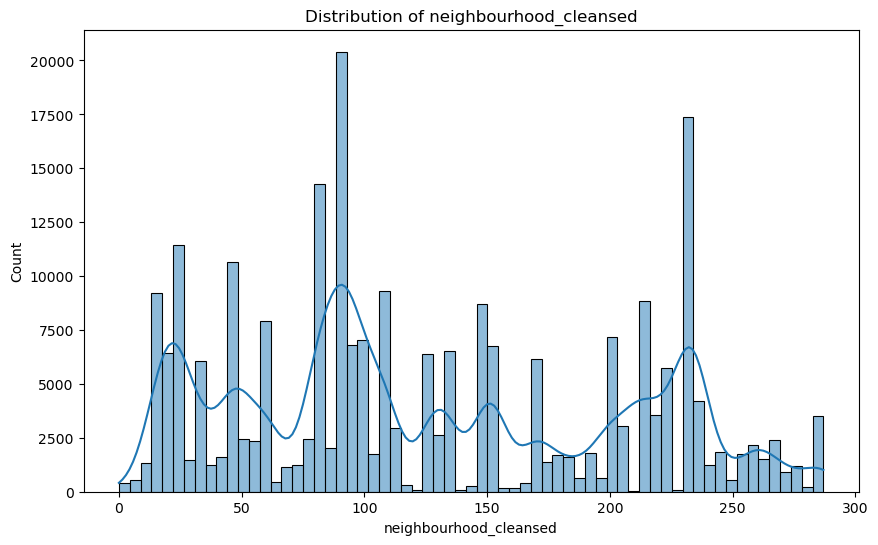

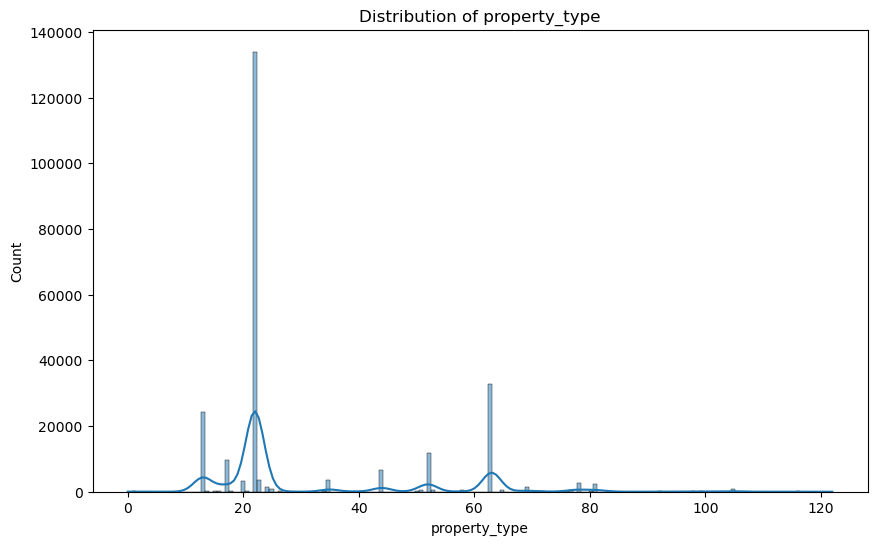

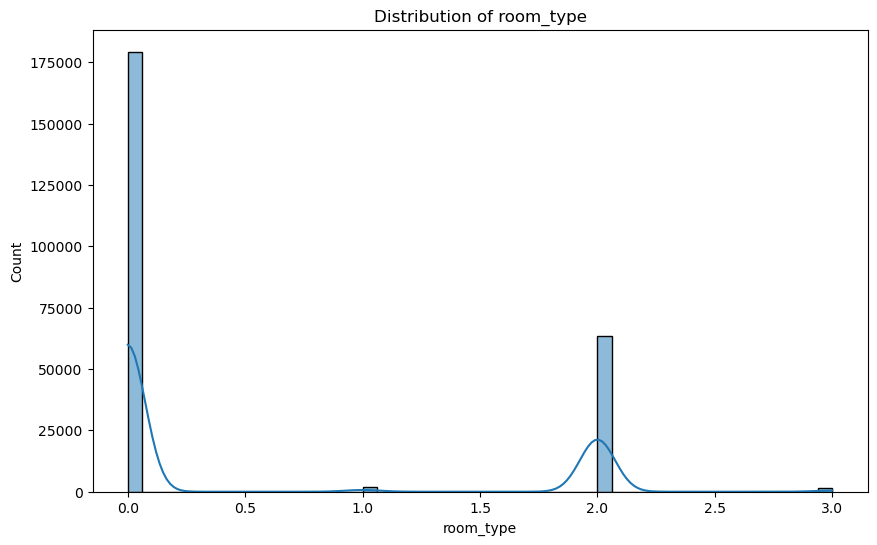

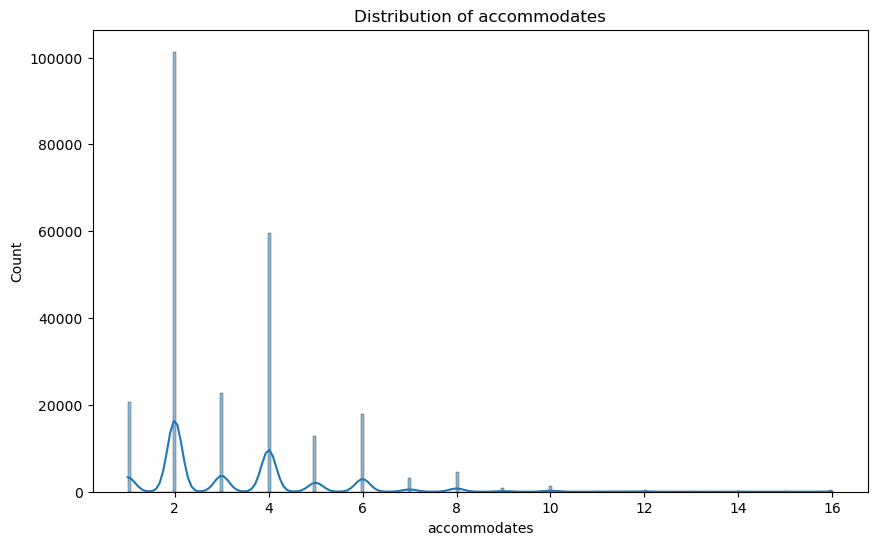

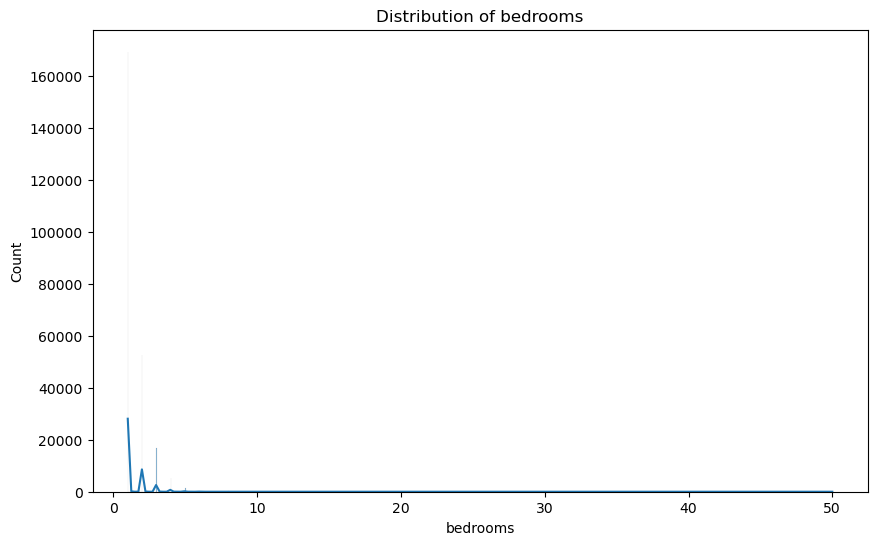

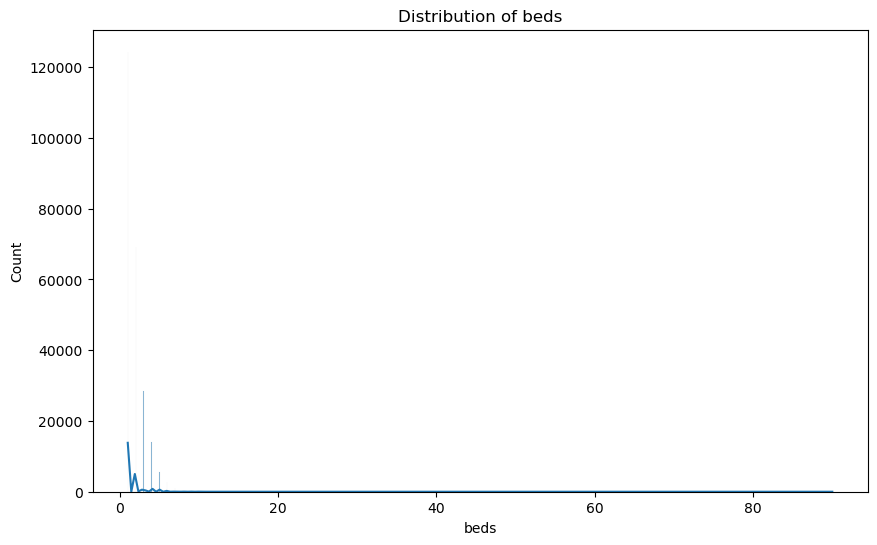

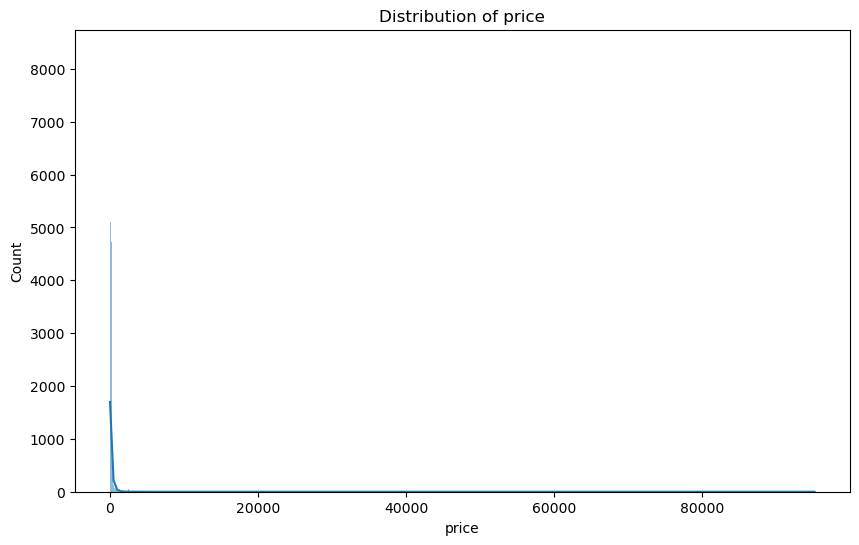

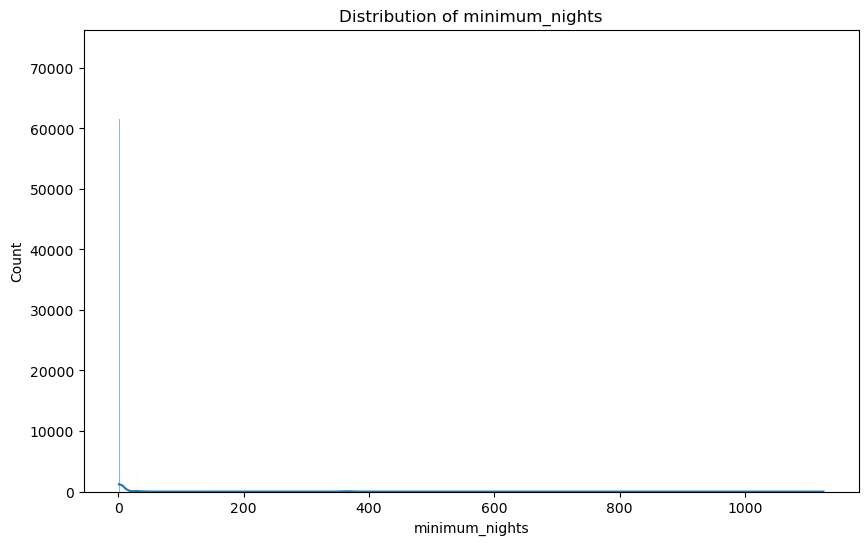

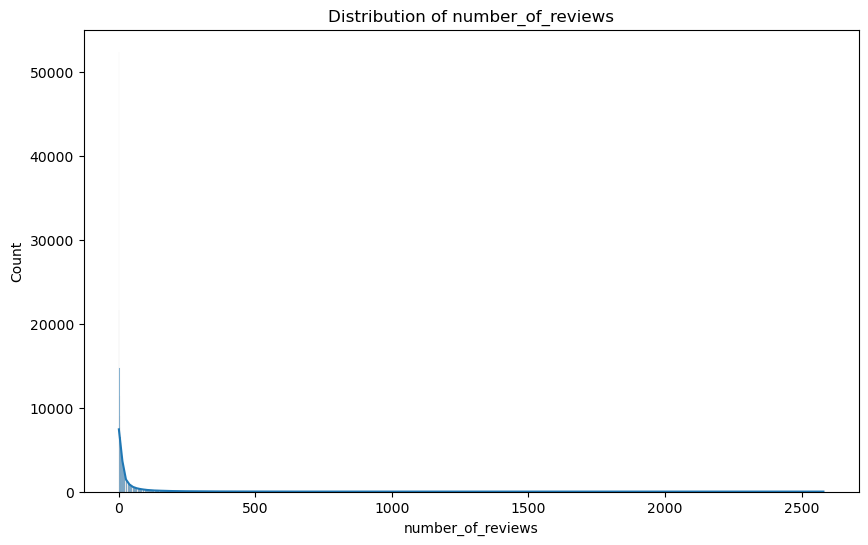

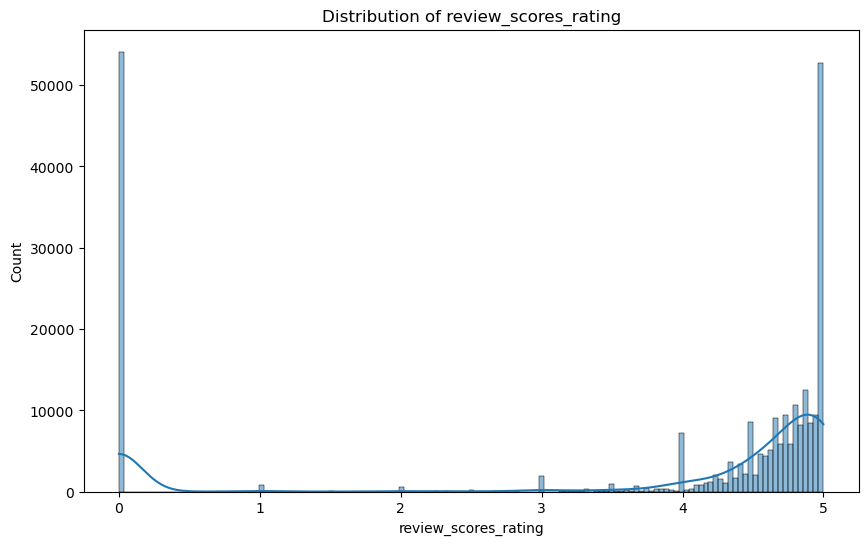

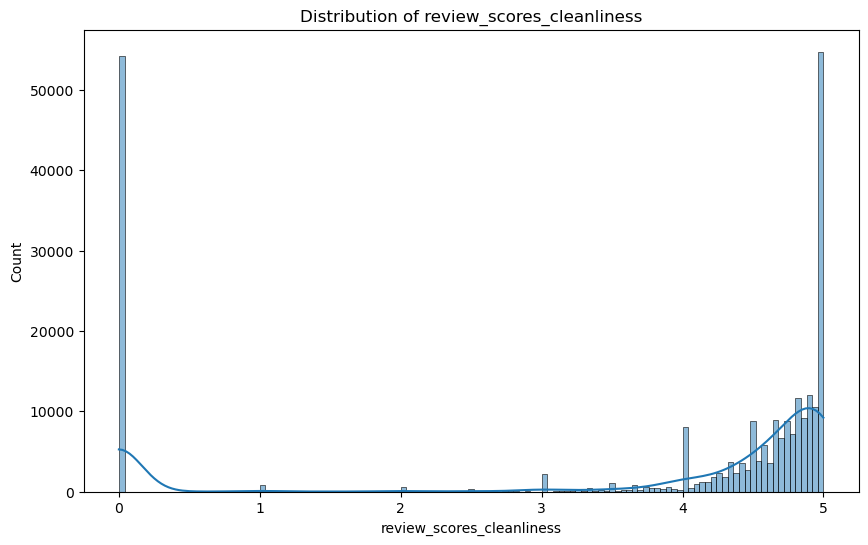

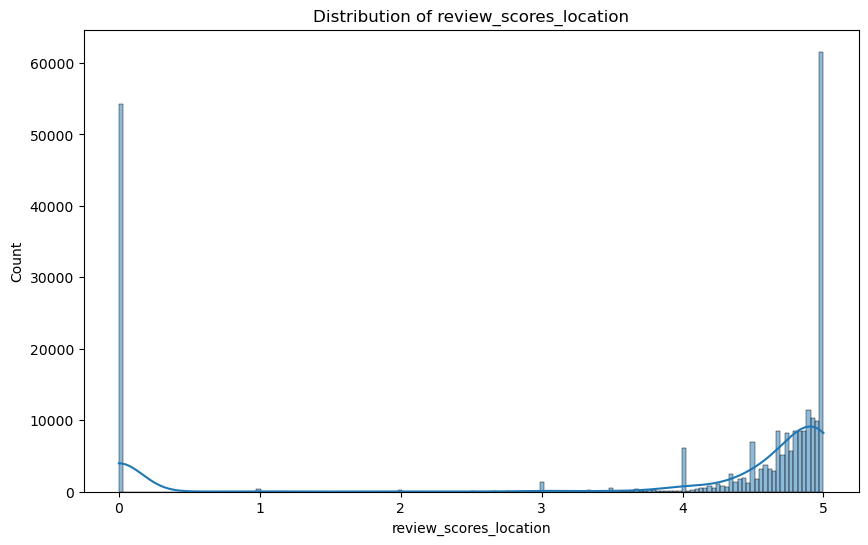

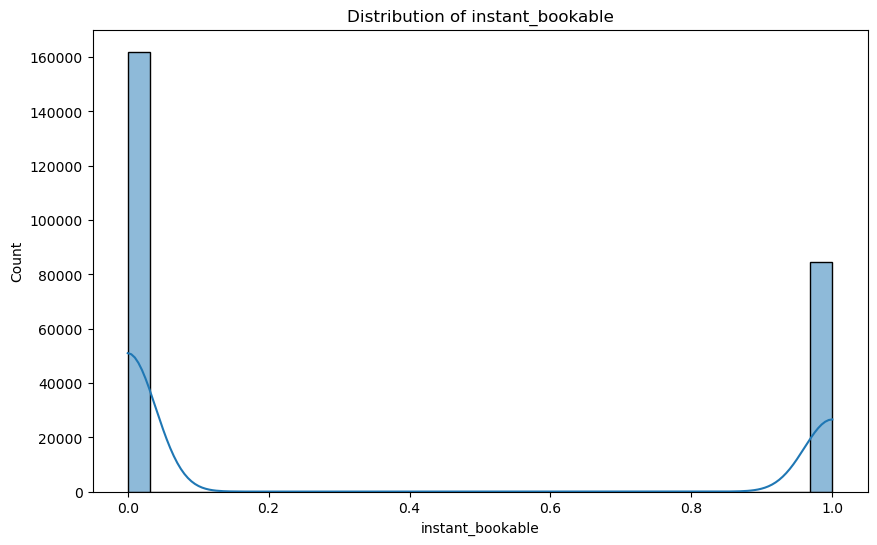

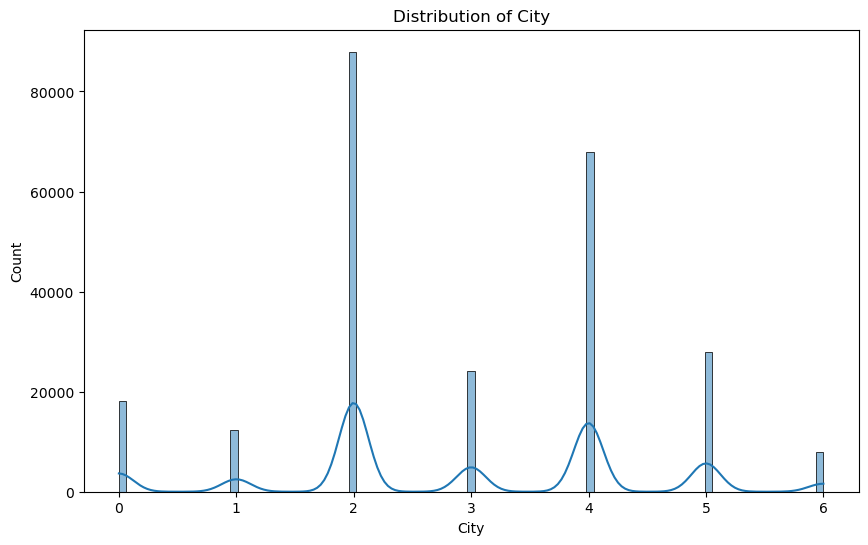

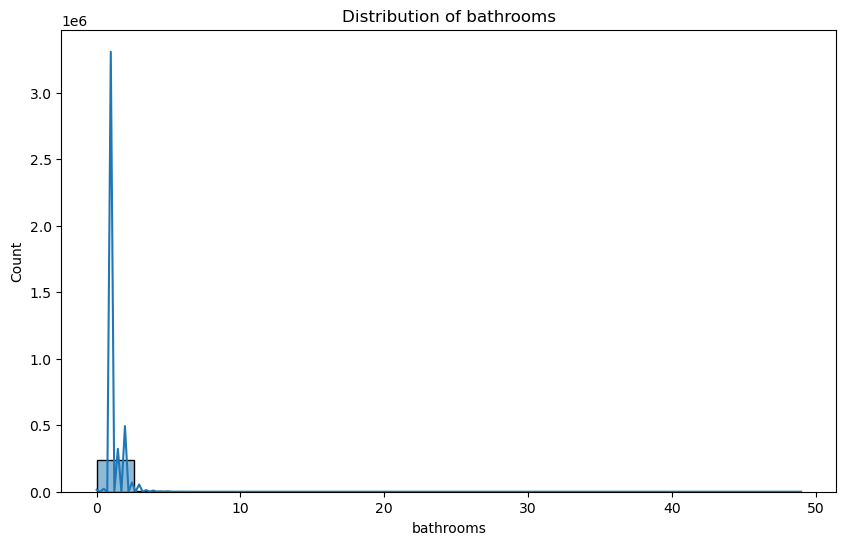

In [26]:
# Loop through each column in the DataFrame
for column in cities_df.columns:   
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(cities_df[column]):
        plt.figure(figsize=(10, 6))
        sns.histplot(cities_df[column], kde=True)
        plt.title(f'Distribution of {column}')
    else:
        # For non-numeric columns
        plt.figure(figsize=(10, 6))
        sns.countplot(data=cities_df, x=column)
        plt.title(f'Counts Per {column}')
        plt.xticks(rotation=45)

    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

### Columns correlation - heatmap overview

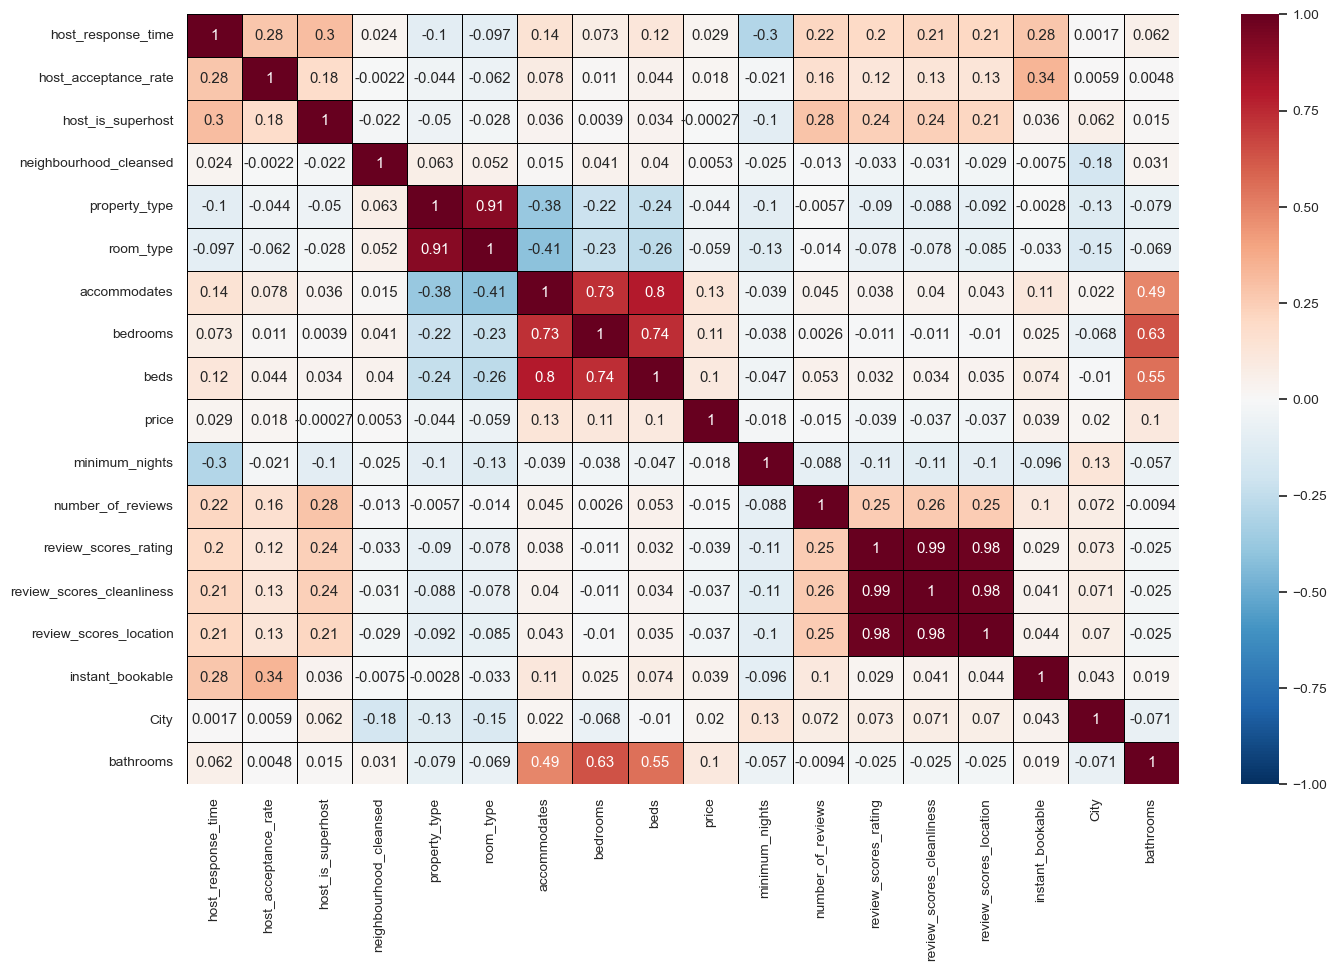

In [27]:
# Select only numeric columns for correlation
numeric_df = cities_df.select_dtypes(include=['float64', 'int64', 'float32', 'int32'])

# Create heatmap
sns.set(font_scale=0.9)
plt.figure(figsize=(16, 10))
sns.heatmap(
    numeric_df.corr(),        
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1,
    linewidths=0.5, 
    linecolor='black',
    square=False
)
plt.show()

## Removing the outliners

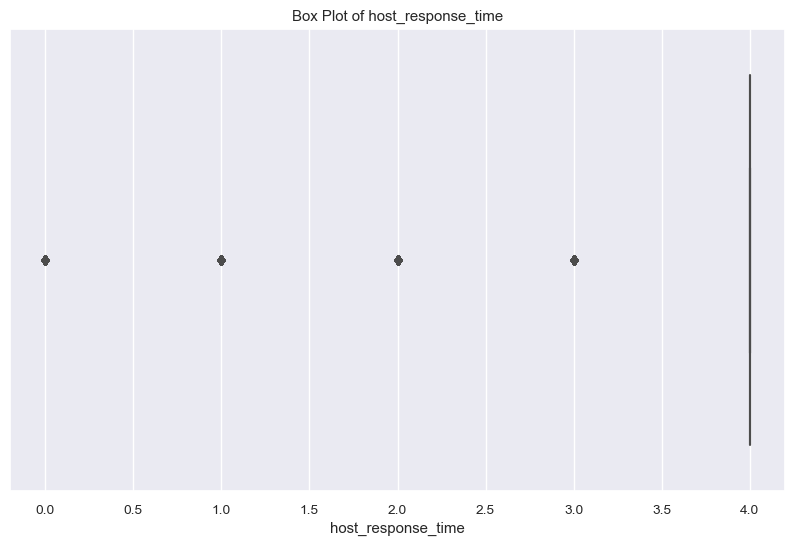

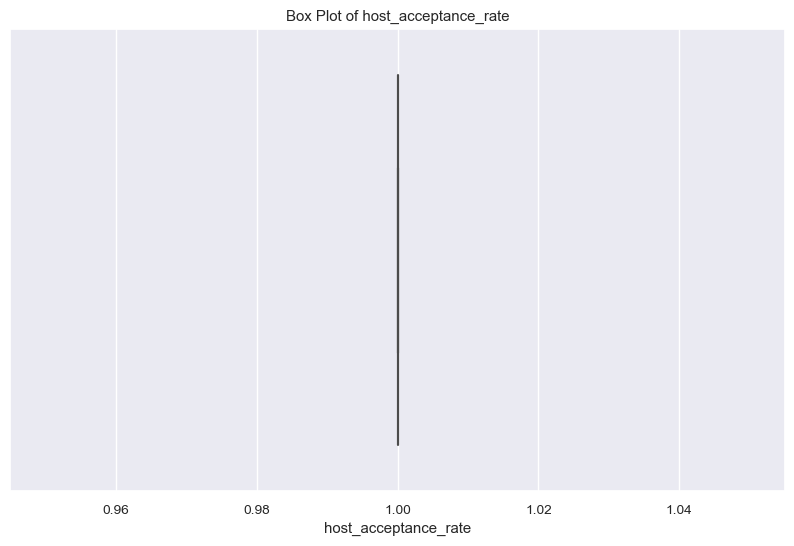

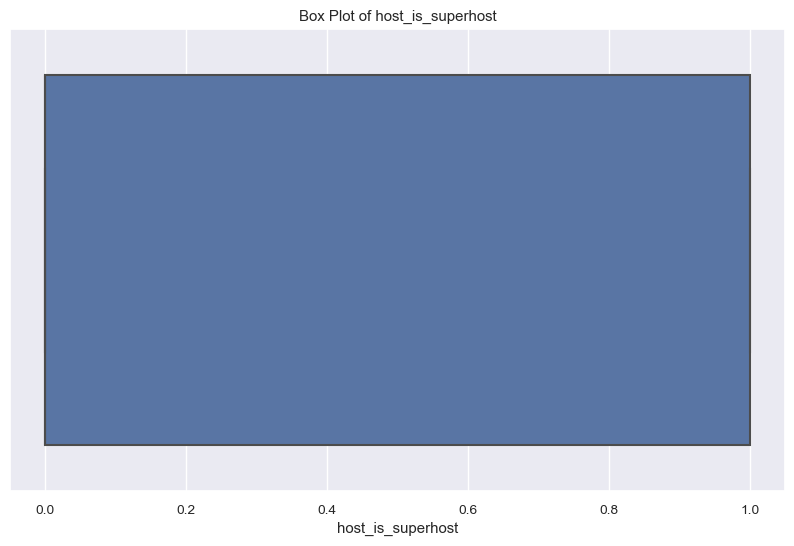

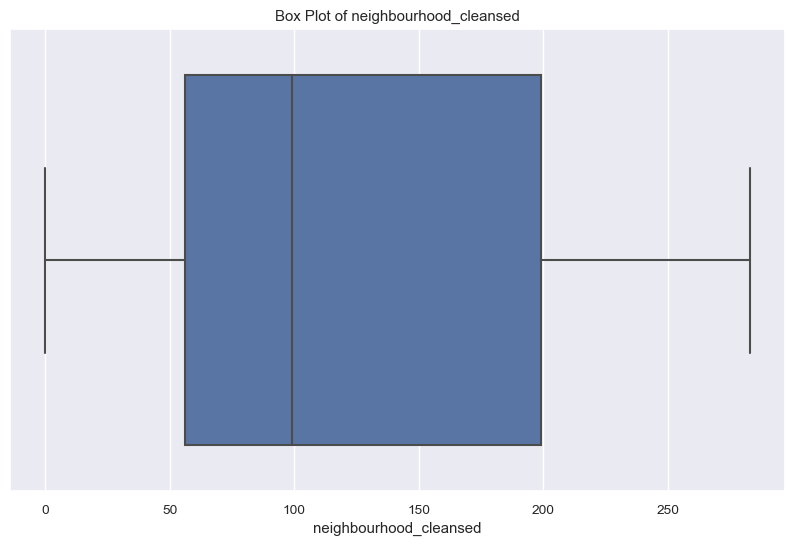

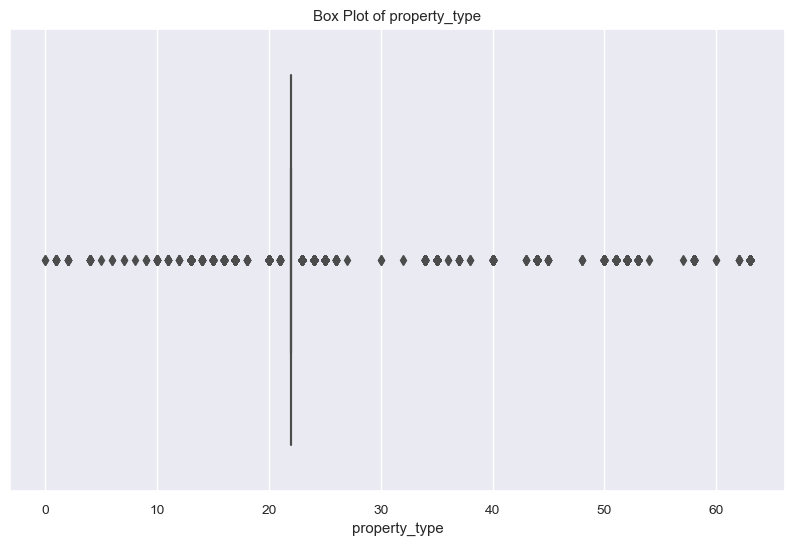

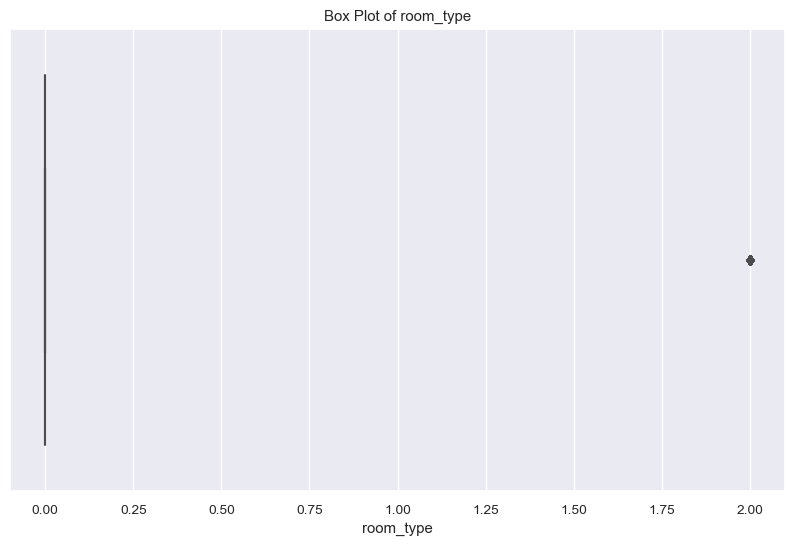

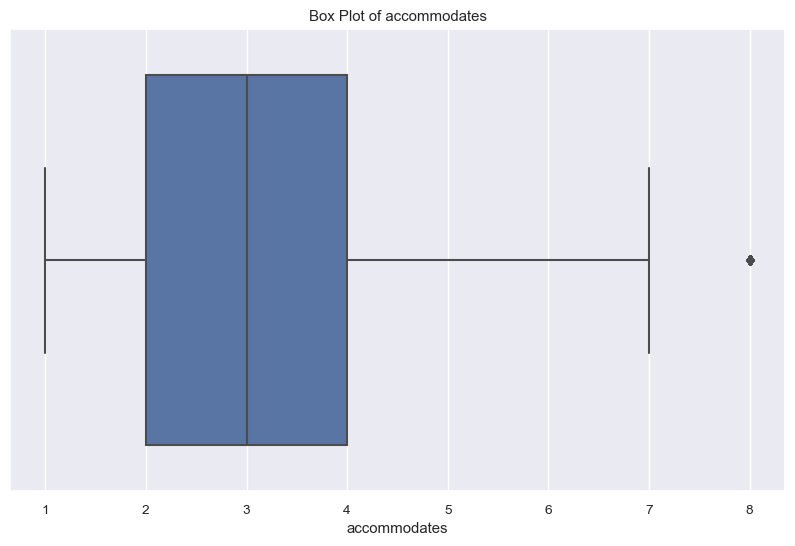

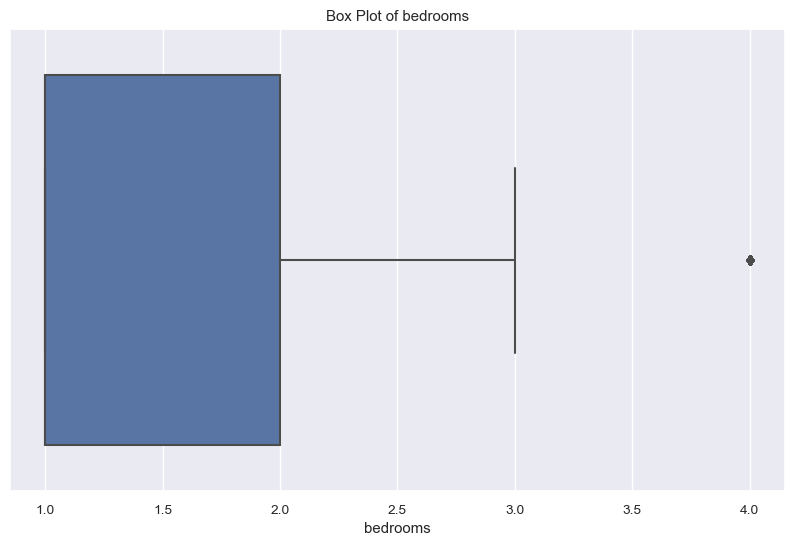

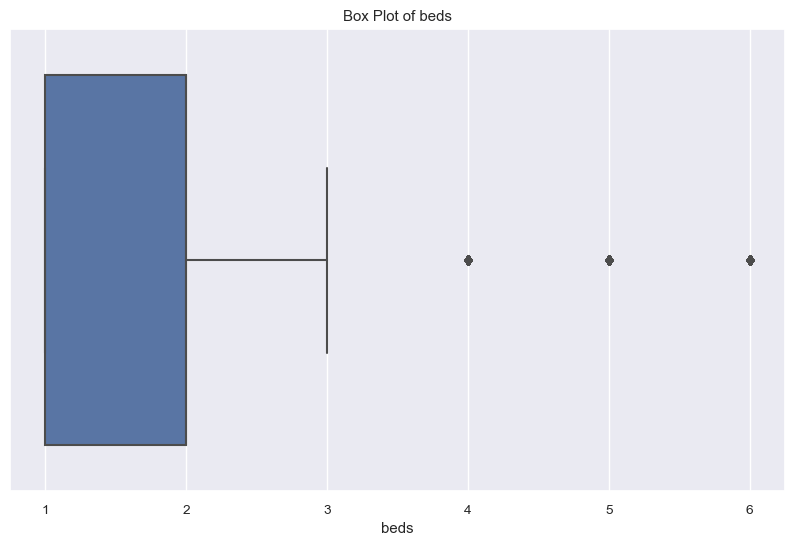

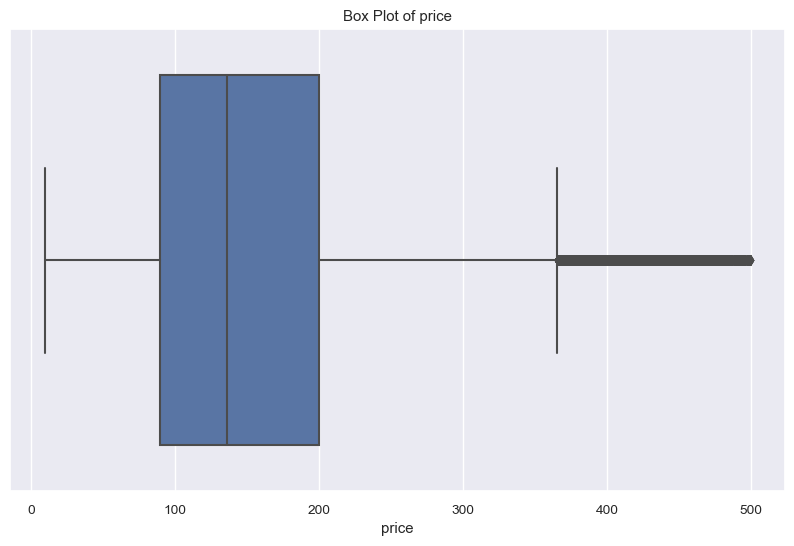

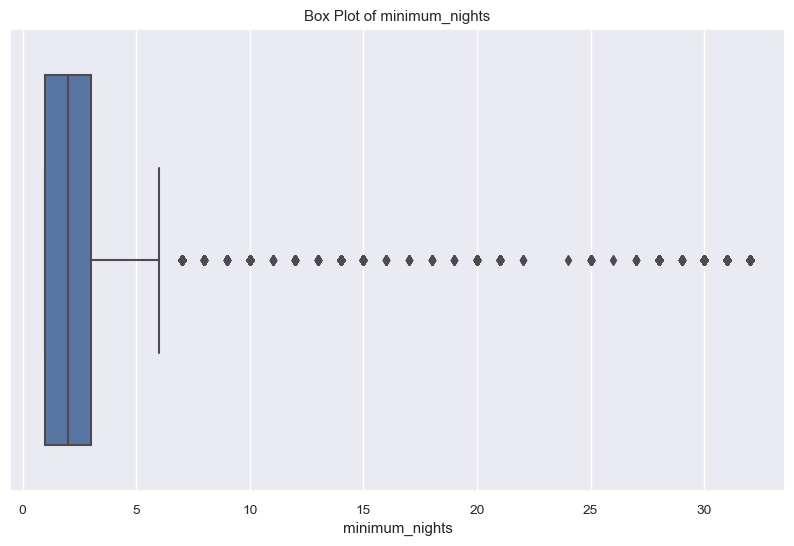

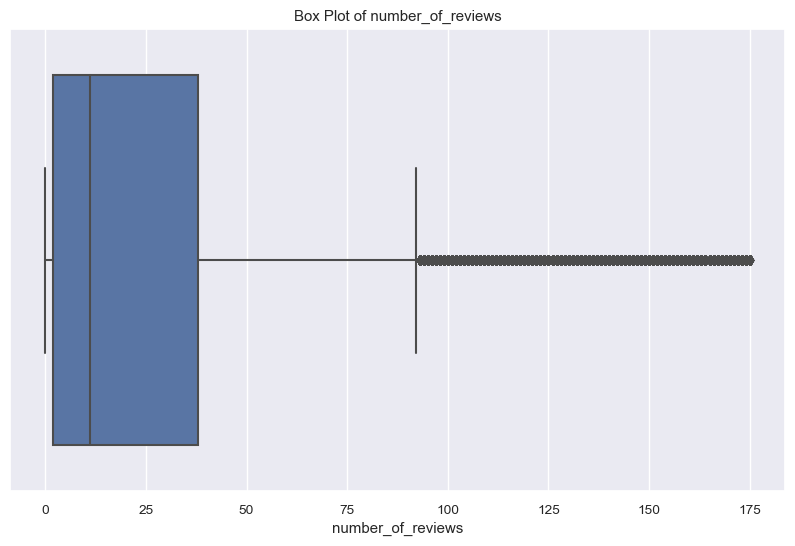

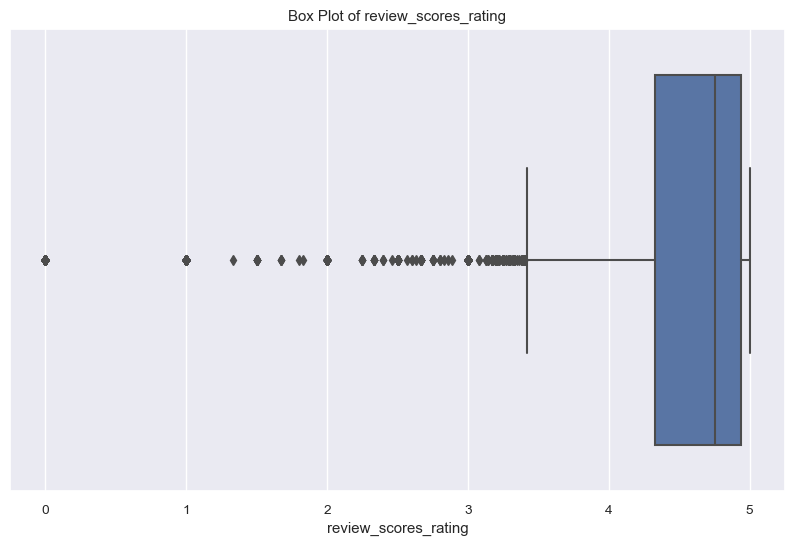

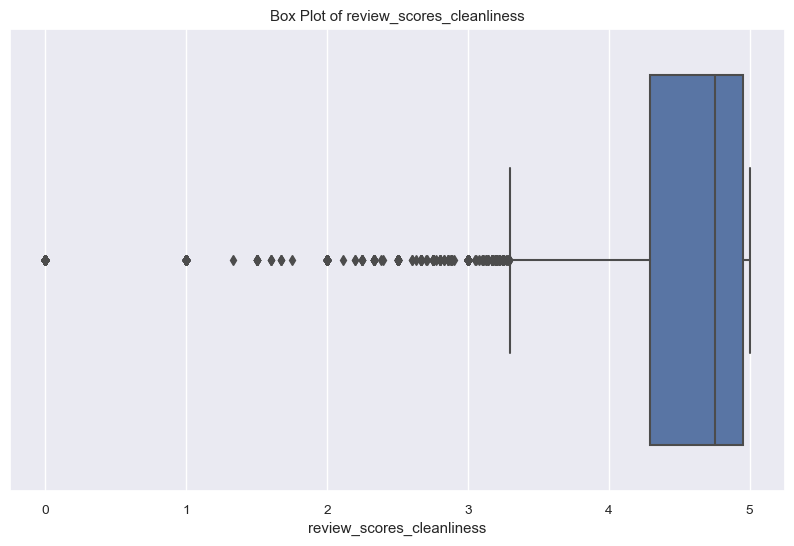

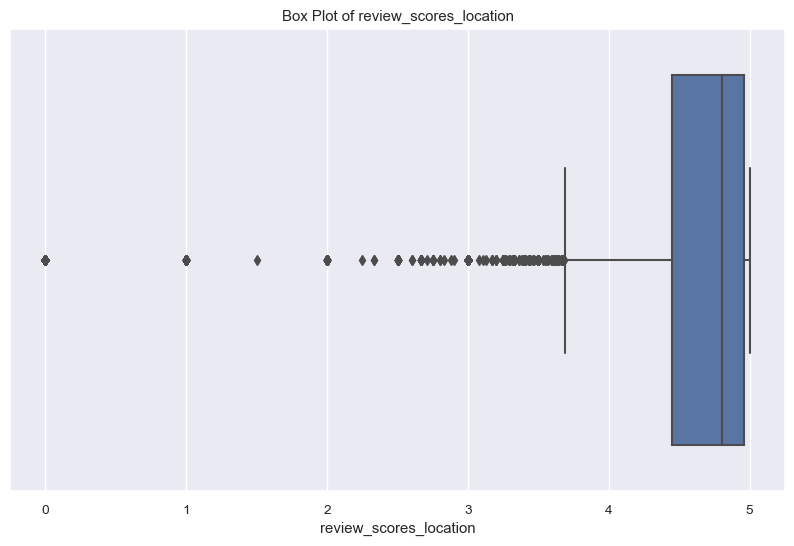

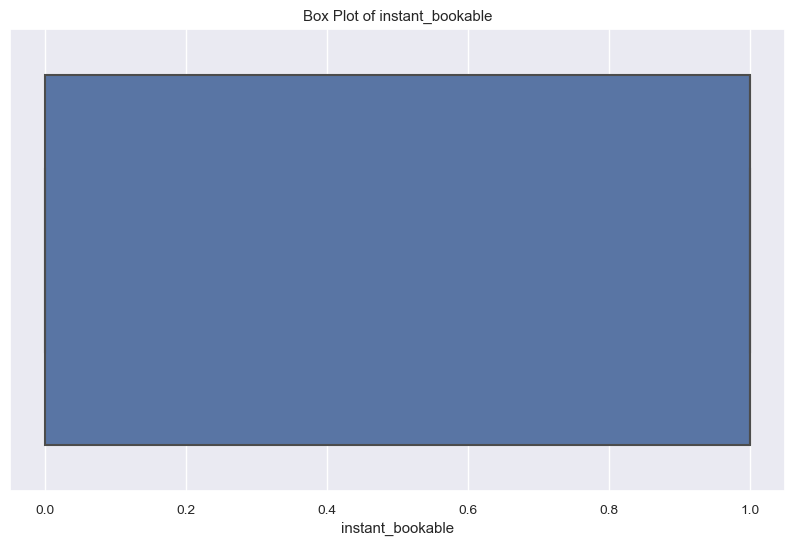

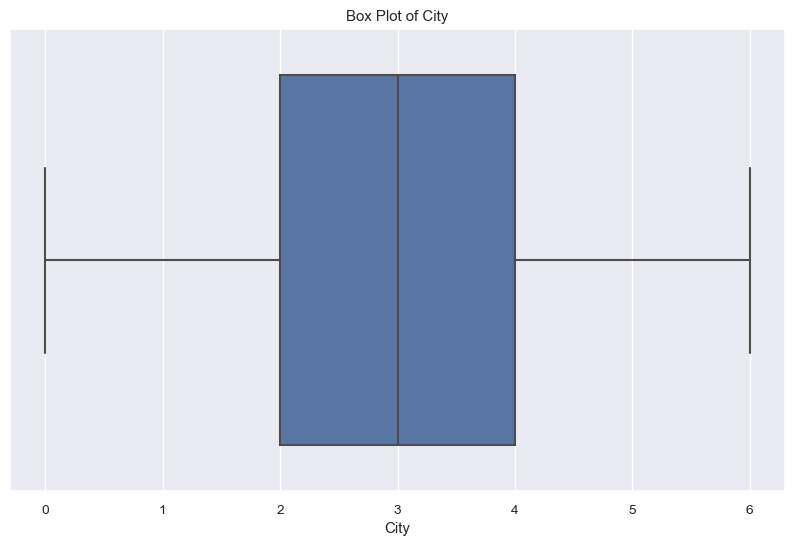

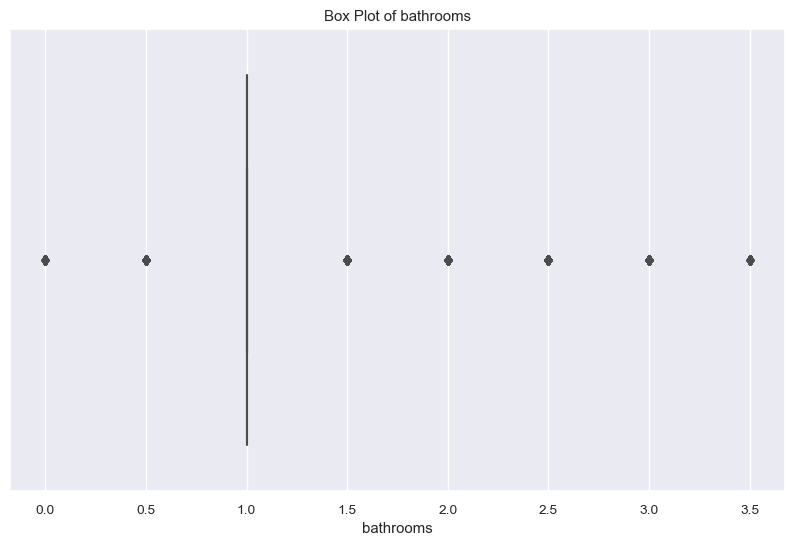

In [28]:
# Define the upper limit for capping
upper_limit_accommodates = cities_df['accommodates'].quantile(0.97)
upper_limit_bedrooms = cities_df['bedrooms'].quantile(0.98)
upper_limit_beds = cities_df['beds'].quantile(0.98)
upper_limit_price = cities_df['price'].quantile(0.95)
upper_limit_minimum_nights = cities_df['minimum_nights'].quantile(0.94)
upper_limit_number_of_reviews = cities_df['number_of_reviews'].quantile(0.96)
upper_limit_bathrooms = cities_df['bathrooms'].quantile(0.99)
upper_limit_property_type = cities_df['property_type'].quantile(0.94)
upper_limit_neighbourhood_cleansed = cities_df['neighbourhood_cleansed'].quantile(0.99)

lower_limit_host_acceptance_rate = cities_df['host_acceptance_rate'].quantile(0.99)

# Cap values at the n'th percentile
cities_df = cities_df[(cities_df['accommodates'] <= upper_limit_accommodates)
                      & (cities_df['bedrooms'] <= upper_limit_bedrooms) 
                      & (cities_df['beds'] <= upper_limit_beds)
                      & (cities_df['price'] <= upper_limit_price) 
                      & (cities_df['minimum_nights'] <= upper_limit_minimum_nights)
                      & (cities_df['number_of_reviews'] <= upper_limit_number_of_reviews)
                      & (cities_df['bathrooms'] <= upper_limit_bathrooms)
                      & (cities_df['property_type'] <= upper_limit_property_type) 
                      & (cities_df['neighbourhood_cleansed'] <= upper_limit_neighbourhood_cleansed)
                      & (cities_df['host_acceptance_rate'] >= lower_limit_host_acceptance_rate)]

# Loop through each column in the DataFrame
for column in cities_df.columns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(cities_df[column]):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=cities_df[column])
        plt.title(f'Box Plot of {column}')
        plt.xlabel(column)
        plt.show()

## Scale the dataframe

In [29]:
cities_df = cities_df.reset_index(drop=True)

# Identify columns to exclude from scaling
columns_to_exclude = ['price'] 

# Exclude columns from scaling
columns_to_scale = [col for col in cities_df.columns 
                    if not (cities_df[col].nunique() == 2 and 
                            set(cities_df[col].unique()) == {0, 1}) and 
                    col not in columns_to_exclude]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the selected columns
cities_df[columns_to_scale] = scaler.fit_transform(cities_df[columns_to_scale])

## Checking for multicollinearity

In [30]:
# Exclude non-numeric columns
numeric_columns = cities_df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
numeric_df = cities_df[numeric_columns]

# Exclude columns that contain only two unique values from VIF calculation
numeric_df = numeric_df.loc[:, numeric_df.apply(lambda x: x.nunique()) > 2]

# Add a constant for the intercept
X = add_constant(numeric_df)

# Create a DataFrame for VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                      feature        VIF
0                       const   5.465800
1          host_response_time   1.035577
2      neighbourhood_cleansed   1.037386
3               property_type   1.286389
4                accommodates   3.860116
5                    bedrooms   2.876877
6                        beds   3.171968
7                       price   1.493737
8              minimum_nights   1.086487
9           number_of_reviews   1.153450
10       review_scores_rating  53.245702
11  review_scores_cleanliness  42.640592
12     review_scores_location  24.457485
13                       City   1.088919
14                  bathrooms   1.461484


### Dropping columns with high VIF

In [31]:
# List of columns to drop
columns_to_drop = [
    'review_scores_cleanliness', 'review_scores_location', 'host_acceptance_rate']

# Dropping the specified columns
cities_df.drop(columns_to_drop, axis=1, inplace=True)

## Splitting the data

In [32]:
X = cities_df.drop('price', axis = 1)

y = cities_df['price']

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.20, random_state=1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(48174, 14)
(48174,)
(12044, 14)
(12044,)


## Training the linear regression model

In [33]:
standard_lr = linear_model.LinearRegression() # we create an object of the LR class
standard_lr.fit(X_train, Y_train) # training / fitting model on data;

standard_lr_Y_pred = standard_lr.predict(X_test) 

In [34]:
print ("\n\nLet's evalaute our model on our held-out test data\n")

print("R-Sqaured: %.3f"
      % standard_lr.score(X_test,Y_test)) # R-squared 

print("Mean squared error: %.3f"
      % mean_squared_error(Y_test, standard_lr_Y_pred))  # Test MSE

print("Mean absolute error: %.3f"
      % mean_absolute_error(Y_test, standard_lr_Y_pred))

print ("\n\n\nLet's see how parameters were learnt in training.\n")

print("The intercept / beta_0 is {}".format(standard_lr.intercept_)) 
for i, col_name in enumerate(X_train.columns):
    print("The coefficient (beta_{}) for {} is {}".format(i, col_name, standard_lr.coef_[i]))



Let's evalaute our model on our held-out test data

R-Sqaured: 0.335
Mean squared error: 5493.129
Mean absolute error: 55.309



Let's see how parameters were learnt in training.

The intercept / beta_0 is 147.44191697067208
The coefficient (beta_0) for host_response_time is -2.3577307356302466
The coefficient (beta_1) for host_is_superhost is 12.930800461712373
The coefficient (beta_2) for neighbourhood_cleansed is -2.794778577727845
The coefficient (beta_3) for property_type is -1.6175241320057498
The coefficient (beta_4) for room_type is -16.6768951243488
The coefficient (beta_5) for accommodates is 24.559778264642212
The coefficient (beta_6) for bedrooms is 14.255082995864031
The coefficient (beta_7) for beds is -4.374677234031574
The coefficient (beta_8) for minimum_nights is -7.890922342223497
The coefficient (beta_9) for number_of_reviews is -5.467239514301536
The coefficient (beta_10) for review_scores_rating is -2.582163226279547
The coefficient (beta_11) for instant_bookabl

## Training ordinary least squares linear regression model

In [35]:
# Add a constant to the training data
x_train_sm = sm.add_constant(X_train)

# Fit the model
ols_lr = sm.OLS(Y_train, x_train_sm).fit()

# Add a constant to the test data
x_test_sm = sm.add_constant(X_test)

# Make predictions on the test data
y_pred_ols = ols_lr.predict(x_test_sm)

In [36]:
print (ols_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1731.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:57:55   Log-Likelihood:            -2.7595e+05
No. Observations:               48174   AIC:                         5.519e+05
Df Residuals:                   48159   BIC:                         5.521e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    147

## Training random forest regressor model

In [37]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=1)

# Fit the model to the training data
rf_regressor.fit(X_train, Y_train)

# Predict on the test data
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(Y_test, y_pred_rf)
r2_rf = r2_score(Y_test, y_pred_rf)
mae_rf = mean_absolute_error(Y_test, y_pred_rf)

In [38]:
# Print the performance metrics
print(f'\nRandom Forest Regressor - Mean Squared Error: {mse_rf}')
print(f'\nRandom Forest Regressor - R^2 Score: {r2_rf}')
print(f'\nRandom Forest Regressor - Mean Absolute Error: {mae_rf}')


Random Forest Regressor - Mean Squared Error: 4268.728209156303

Random Forest Regressor - R^2 Score: 0.483466651271404

Random Forest Regressor - Mean Absolute Error: 46.65925228849352


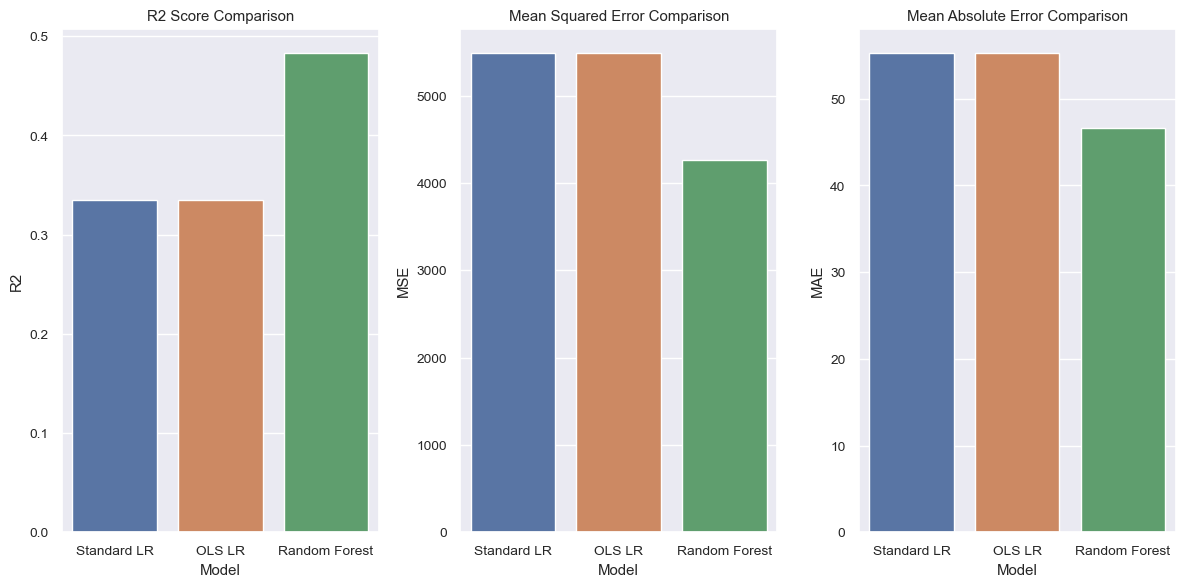

In [39]:
# Calculate metrics for each model
mse_standard_lr = mean_squared_error(Y_test, standard_lr_Y_pred)
r2_standard_lr = r2_score(Y_test, standard_lr_Y_pred)
mae_standard_lr = mean_absolute_error(Y_test, standard_lr_Y_pred)

mse_ols_lr = mean_squared_error(Y_test, y_pred_ols)
r2_ols_lr = r2_score(Y_test, y_pred_ols)
mae_ols_lr = mean_absolute_error(Y_test, y_pred_ols)

mse_rf = mean_squared_error(Y_test, y_pred_rf)
r2_rf = r2_score(Y_test, y_pred_rf)
mae_rf = mean_absolute_error(Y_test, y_pred_rf)

# Create a DataFrame to store all the metrics
metrics_df = pd.DataFrame({
    'Model': ['Standard LR', 'OLS LR', 'Random Forest'],
    'MSE': [mse_standard_lr, mse_ols_lr, mse_rf],
    'R2': [r2_standard_lr, r2_ols_lr, r2_rf],
    'MAE': [mae_standard_lr, mae_ols_lr, mae_rf]
})

# Plotting
plt.figure(figsize=(12, 6))

# R2 Score plot
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='R2', data=metrics_df)
plt.title('R2 Score Comparison')

# MSE plot
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MSE', data=metrics_df)
plt.title('Mean Squared Error Comparison')

# MAE plot
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='MAE', data=metrics_df)
plt.title('Mean Absolute Error Comparison')

plt.tight_layout()
plt.show()

In [40]:
# Print feature importances
importances = rf_regressor.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

print("\nFeature importances:")
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {importances[idx]}")


Feature importances:
accommodates: 0.18155327155085
neighbourhood_cleansed: 0.1510158411906561
number_of_reviews: 0.11821702194308009
property_type: 0.0918968461685281
review_scores_rating: 0.08983377462288011
bathrooms: 0.0803808332794326
minimum_nights: 0.07305557627810551
bedrooms: 0.0591494975010384
City: 0.05113504149384918
beds: 0.03383388143690548
host_response_time: 0.030486849138179756
instant_bookable: 0.02079750434951731
host_is_superhost: 0.0173441034435874
room_type: 0.0012999576033899075
